In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
#import case data
county_cases = pd.read_csv('./data/us-counties-recent.csv',dtype={'fips':str, 'date':str})

In [3]:
#selecting only the most recent data
county_cases = county_cases[county_cases['date'] == str(pd.to_datetime(county_cases['date']).max()).split(' 00:')[0]]

In [4]:
#selecting the relevant columns for out analysis
county_cases = county_cases[['county','state','fips','cases','deaths']]

In [5]:
#dropping rows where deaths is null (just Puerto Rico)
county_cases = county_cases[county_cases['deaths'] >= 0]

In [6]:
#selecting only the rows that have county information
county_cases = county_cases[county_cases['fips'].isnull() == False]

In [7]:
#rename fips columns for merging purposes
county_cases.rename(columns={'fips':'county_fips_code'}, inplace=True)

In [8]:
census_pop = pd.read_csv('./data/cc-est2019-alldata.csv',
                         encoding = "ISO-8859-1",dtype={'STATE':str,
                                                        'COUNTY':str})

In [9]:
#selecting the relevant information from the census dataset
census_pop = census_pop[(census_pop['AGEGRP'] == 0) & (
    census_pop['YEAR']==12) & (census_pop['SUMLEV']==50)]
census_pop = census_pop[['STNAME','CTYNAME','STATE','COUNTY','TOT_POP']]
census_pop['COUNTY'] = census_pop['STATE'] + census_pop['COUNTY']
census_pop.rename(columns={'COUNTY':'county_fips_code'},inplace=True)
census_pop.columns = census_pop.columns.str.lower()
census_pop.drop(columns='state',inplace=True)

In [10]:
#merging the data
county_cases = county_cases.merge(census_pop,how='left',on='county_fips_code')

In [11]:
#creating our target variable deaths per hundred thousand population
county_cases['deaths_per_hun_thou'] = 100_000 * (
    county_cases['deaths'] / county_cases['tot_pop'])

In [12]:
#examining the nulls
county_cases[county_cases['tot_pop'].isnull() == True]

,county,state,county_fips_code,cases,deaths,stname,ctyname,tot_pop,deaths_per_hun_thou
71,Bristol Bay plus Lake and Peninsula,Alaska,02997,616,1.0,NaN,NaN,NaN,NaN
92,Yakutat plus Hoonah-Angoon,Alaska,02998,381,4.0,NaN,NaN,NaN,NaN
2036,Saipan,Northern Mariana Islands,69110,3507,18.0,NaN,NaN,NaN,NaN
2037,Tinian,Northern Mariana Islands,69120,11,0.0,NaN,NaN,NaN,NaN
2704,Pending County Assignment,Texas,48999,65,0.0,NaN,NaN,NaN,NaN
2816,St. Croix,Virgin Islands,78010,6658,38.0,NaN,NaN,NaN,NaN
2817,St. John,Virgin Islands,78020,672,5.0,NaN,NaN,NaN,NaN
2818,St. Thomas,Virgin Islands,78030,6571,48.0,NaN,NaN,NaN,NaN


In [13]:
#dropping the nulls
county_cases.dropna(inplace=True)

In [14]:
#read in case data
covid_cases = county_cases

In [15]:
covid_cases.head()

,county,state,county_fips_code,cases,deaths,stname,ctyname,tot_pop,deaths_per_hun_thou
0,Autauga,Alabama,01001,12738,163.0,Alabama,Autauga County,55869.0,291.753924
1,Baldwin,Alabama,01003,47143,605.0,Alabama,Baldwin County,223234.0,271.016064
2,Barbour,Alabama,01005,4741,83.0,Alabama,Barbour County,24686.0,336.222960
3,Bibb,Alabama,01007,5385,95.0,Alabama,Bibb County,22394.0,424.220773
4,Blount,Alabama,01009,12648,203.0,Alabama,Blount County,57826.0,351.053159


In [16]:
#read in unemployment data
unemp = pd.read_excel(
    './data/laucnty20.xlsx',skiprows=range(0,5),dtype={
        'Unnamed: 1':str,'Unnamed: 2':str})

In [17]:
unemp.drop(columns='Unnamed: 5',inplace=True)

In [18]:
#renaming the columns
unemp.rename(columns={'Unnamed: 0': 'laus_code',
                     'Unnamed: 1': 'state_fips_code',
                     'Unnamed: 2': 'cnty_fips_code',
                     'Unnamed: 3': 'cnty_name',
                     'Unnamed: 4': 'year',
                     'Unnamed: 5': 'labor_force',
                     'Unnamed: 6': 'employed',
                     'Unnamed: 7': 'unemployed',
                     'Unnamed: 9': 'unemployment_rate'},inplace=True)

In [19]:
#creating county fips code from the county and state fips codes
unemp['county_fips_code'] = unemp['state_fips_code'] + unemp['cnty_fips_code']

In [20]:
#merging the data
covid_cases = covid_cases.merge(unemp[['county_fips_code',
                                       'cnty_name',
                                       'unemployment_rate']],
                                how='left',on='county_fips_code')

In [21]:
#converting unemployment rate to float
covid_cases['unemployment_rate'] = covid_cases['unemployment_rate'].astype(float)

### Community Transmissibility

The number of total new cases and the percentage of NAAT tests that are positive in a 7 day window per county are included in the United States COVID-19 County Level of Community Transmission as Originally Posted data set. The data are reported on a weekly basis and the level of community transmissibility as defined by the CDC (i.e., low,moderate,high,substantial is included in the data set.

From this data set, for each county, find the median number of total new cases and percentage of positive tests per 7-day period and the percentage of report dates the county belonged to one of the community transmissibility levels.

In [23]:
#importing the data
comm_transmission = pd.read_csv('./data/United_States_COVID-19_County_Level_of_Community_Transmission_Historical_Changes.csv',
                               dtype={'fips_code':str})

In [24]:
comm_transmission.sort_values(['fips_code','date']).head()

,state_name,county_name,fips_code,date,cases_per_100K_7_day_count_change,percent_test_results_reported_positive_last_7_days,community_transmission_level
1535094,Alabama,Autauga County,01001,01/01/2021,445.685,30.73,high
2573086,Alabama,Autauga County,01001,01/01/2022,417.047,32.97,high
2388231,Alabama,Autauga County,01001,01/02/2021,481.483,32.54,high
2696424,Alabama,Autauga County,01001,01/02/2022,707.011,32.45,high
1115872,Alabama,Autauga County,01001,01/03/2021,494.013,33.17,high


In [25]:
#changing supressed value in number of new cases feature to NaN

comm_transmission['cases_per_100K_7_day_count_change'] = comm_transmission[
    'cases_per_100K_7_day_count_change'].\
    replace('suppressed',np.nan).replace(',','',regex=True).astype(float)

# This resource was helpful in converting the string feature to a float type variable.
# https://stackoverflow.com/questions/44966528/pandas-astype-error-string-to-float-could-not-convert-string-to-float-7-50

#### For each county, calculate the median number of new cases and percentage of positive tests per reporting period

In [26]:
med_cases_per_100k_change = pd.DataFrame(comm_transmission.groupby(
    'fips_code')['cases_per_100K_7_day_count_change'].median())

In [27]:
med_cases_per_100k_change['fips_code'] = med_cases_per_100k_change.index

In [28]:
med_cases_per_100k_change.reset_index(inplace=True,drop=True)

In [29]:
med_cases_per_100k_change.rename(columns={
    'cases_per_100K_7_day_count_change':'med_cases_per_100k_change'},
                                inplace=True)

In [30]:
med_per_test_results_positive = pd.DataFrame(comm_transmission.groupby(
    'fips_code')['percent_test_results_reported_positive_last_7_days'].median())

In [31]:
med_per_test_results_positive['fips_code'] = med_per_test_results_positive.index

In [32]:
med_per_test_results_positive.reset_index(drop=True,inplace=True)

In [33]:
med_per_test_results_positive.rename(columns={
    'percent_test_results_reported_positive_last_7_days':'med_per_test_results_positive'},
                                inplace=True)

In [34]:
comm_transmission = comm_transmission.merge(med_cases_per_100k_change,
                                            how='left', on='fips_code')

In [35]:
comm_transmission = comm_transmission.merge(
    med_per_test_results_positive, how='left', on='fips_code')

#### For each county, calculate the percentage of reporting dates where the transmissibility level belonged to a category

In [36]:
comm_transmission = pd.get_dummies(comm_transmission,columns=[
    'community_transmission_level'])

In [37]:
community_transmission = comm_transmission.groupby('fips_code')[[
    'community_transmission_level_high',
    'community_transmission_level_low',
    'community_transmission_level_moderate',
    'community_transmission_level_substantial']].mean()

In [38]:
community_transmission.columns = community_transmission.columns.str.replace(
    'community_','')

In [39]:
community_transmission['fips_code'] = community_transmission.index

In [40]:
community_transmission.reset_index(drop=True,inplace=True)

In [41]:
comm_transmission = comm_transmission.merge(
    community_transmission,how='left',on='fips_code')

In [42]:
comm_transmission = comm_transmission[['fips_code','med_cases_per_100k_change',
                                       'med_per_test_results_positive',
                                       'transmission_level_high',
                                       'transmission_level_low',
                                       'transmission_level_moderate',
                                       'transmission_level_substantial']]

In [43]:
comm_transmission.drop_duplicates(inplace=True)

In [44]:
comm_transmission.rename(columns={'fips_code':'county_fips_code'},inplace=True)

#### Merge the data with the COVID cases data frame

In [45]:
covid_cases = covid_cases.merge(
    comm_transmission,how='left',on='county_fips_code')

In [46]:
hosp_capacity = pd.read_csv('./data/covid19-NatEst.csv')

These are the variables considered for this analysis from the hospital capacity data set:

InBedsOccAnyPat__Numbeds_Est - Hospital inpatient bed occupancy, percent estimate (percent of inpatient beds)
InBedsOccCOVID__Numbeds_Est - Number of patients in an inpatient care location who have suspected or confirmed COVID-19, percent estimate (percent of inpatient beds)
ICUBedsOccAnyPat__N_ICUBeds_Est - ICU bed occupancy, percent estimate (percent of ICU beds)

In [47]:
hosp_capacity = hosp_capacity[['state','statename',
                               'collectionDate',
                              'InBedsOccAnyPat__Numbeds_Est',
                               'InBedsOccCOVID__Numbeds_Est',
                               'ICUBedsOccAnyPat__N_ICUBeds_Est']]

In [48]:
hosp_capacity = hosp_capacity.drop(index=0)

In [49]:
#converting to float
hosp_capacity['InBedsOccAnyPat__Numbeds_Est'] = hosp_capacity[
    'InBedsOccAnyPat__Numbeds_Est'].astype(float)

hosp_capacity['InBedsOccCOVID__Numbeds_Est'] = hosp_capacity[
    'InBedsOccCOVID__Numbeds_Est'].astype(float)

hosp_capacity['ICUBedsOccAnyPat__N_ICUBeds_Est'] = hosp_capacity[
    'ICUBedsOccAnyPat__N_ICUBeds_Est'].astype(float)

In [50]:
hosp_capacity_states = hosp_capacity.groupby('state')[[
    'InBedsOccAnyPat__Numbeds_Est',
    'InBedsOccCOVID__Numbeds_Est',
    'ICUBedsOccAnyPat__N_ICUBeds_Est']].median()

In [51]:
hosp_capacity_states.reset_index(inplace=True)

In [52]:
states = {"AL":"Alabama",
          "AK":"Alaska",
          "AZ":"Arizona",
          "AR":"Arkansas",
          "CA":"California",
          "CO":"Colorado",
          "CT":"Connecticut",
          "DE":"Delaware",
          "FL":"Florida",
          "GA":"Georgia",
          "HI":"Hawaii",
          "ID":"Idaho",
          "IL":"Illinois",
          "IN":"Indiana",
          "IA":"Iowa",
          "KS":"Kansas",
          "KY":"Kentucky",
          "LA":"Louisiana",
          "ME":"Maine",
          "MD":"Maryland",
          "MA":"Massachusetts",
          "MI":"Michigan",
          "MN":"Minnesota",
          "MS":"Mississippi",
          "MO":"Missouri",
          "MT":"Montana",
          "NE":"Nebraska",
          "NV":"Nevada",
          "NH":"New Hampshire",
          "NJ":"New Jersey",
          "NM":"New Mexico",
          "NY":"New York",
          "NC":"North Carolina",
          "ND":"North Dakota",
          "OH":"Ohio",
          "OK":"Oklahoma",
          "OR":"Oregon",
          "PA":"Pennsylvania",
          "RI":"Rhode Island",
          "SC":"South Carolina",
          "SD":"South Dakota",
          "TN":"Tennessee",
          "TX":"Texas",
          "UT":"Utah",
          "VT":"Vermont",
          "VA":"Virginia",
          "WA":"Washington",
          "WV":"West Virginia",
          "WI":"Wisconsin",
          "WY":"Wyoming"}

In [53]:
covid_cases['st_abbr'] = ""

In [54]:
for key,value in states.items():
    covid_cases.loc[covid_cases['state']==value,'st_abbr'] = key

In [55]:
covid_cases.drop(columns='state',inplace=True)
covid_cases.rename(columns={'st_abbr':'state'},inplace=True)

In [56]:
covid_cases = covid_cases.merge(hosp_capacity_states,how='left',on='state')

In [57]:
covid_cases['cases_per_10k'] = 10000 * (
    covid_cases['cases'] / covid_cases['tot_pop'])

In [58]:
covid_cases['high_transmission'] = covid_cases[
    'transmission_level_high'] + covid_cases['transmission_level_substantial']

In [59]:
# #save as csv
# covid_cases.to_csv(
#     './data/covid-cases-transmissibility-unemployment-hospital-capacity.csv',
#     index=False)

# Re-Import and merge

In [60]:
county_cases = covid_cases

# county_cases = pd.read_csv(
#     './data/covid-cases-transmissibility-unemployment-hospital-capacity.csv',
#     dtype={'county_fips_code':str})

In [61]:
county_cases.head()

,county,county_fips_code,cases,deaths,stname,ctyname,tot_pop,deaths_per_hun_thou,cnty_name,unemployment_rate,...,transmission_level_high,transmission_level_low,transmission_level_moderate,transmission_level_substantial,state,InBedsOccAnyPat__Numbeds_Est,InBedsOccCOVID__Numbeds_Est,ICUBedsOccAnyPat__N_ICUBeds_Est,cases_per_10k,high_transmission
0,Autauga,01001,12738,163.0,Alabama,Autauga County,55869.0,291.753924,"Autauga County, AL",4.9,...,0.723077,0.071006,0.113609,0.084024,AL,66.05,6.6,73.3,2279.976373,0.807101
1,Baldwin,01003,47143,605.0,Alabama,Baldwin County,223234.0,271.016064,"Baldwin County, AL",5.6,...,0.492308,0.089941,0.182249,0.227219,AL,66.05,6.6,73.3,2111.819884,0.719527
2,Barbour,01005,4741,83.0,Alabama,Barbour County,24686.0,336.222960,"Barbour County, AL",7.0,...,0.623669,0.115976,0.143195,0.108876,AL,66.05,6.6,73.3,1920.521753,0.732544
3,Bibb,01007,5385,95.0,Alabama,Bibb County,22394.0,424.220773,"Bibb County, AL",6.6,...,0.575148,0.093491,0.151479,0.171598,AL,66.05,6.6,73.3,2404.661963,0.746746
4,Blount,01009,12648,203.0,Alabama,Blount County,57826.0,351.053159,"Blount County, AL",4.1,...,0.681657,0.094675,0.120710,0.094675,AL,66.05,6.6,73.3,2187.251409,0.776331


In [62]:
county_cases.shape

(3133, 22)

In [63]:
#importing and renaming the mask usage variables for clarity

mask_usage = pd.read_csv('./data/mask-use-by-county.csv', dtype={'COUNTYFP':str})
mask_usage.rename(columns={'COUNTYFP':'county_fips_code',
                           'NEVER':'mask_never',
              'RARELY':'mask_rarely',
              'SOMETIMES':'mask_sometimes',
              'FREQUENTLY':'mask_frequently',
              'ALWAYS':'mask_always'}, inplace=True)                     

In [64]:
county_cases = county_cases.merge(mask_usage, on='county_fips_code', how='left')

In [65]:
county_cases.head()

,county,county_fips_code,cases,deaths,stname,ctyname,tot_pop,deaths_per_hun_thou,cnty_name,unemployment_rate,...,InBedsOccAnyPat__Numbeds_Est,InBedsOccCOVID__Numbeds_Est,ICUBedsOccAnyPat__N_ICUBeds_Est,cases_per_10k,high_transmission,mask_never,mask_rarely,mask_sometimes,mask_frequently,mask_always
0,Autauga,01001,12738,163.0,Alabama,Autauga County,55869.0,291.753924,"Autauga County, AL",4.9,...,66.05,6.6,73.3,2279.976373,0.807101,0.053,0.074,0.134,0.295,0.444
1,Baldwin,01003,47143,605.0,Alabama,Baldwin County,223234.0,271.016064,"Baldwin County, AL",5.6,...,66.05,6.6,73.3,2111.819884,0.719527,0.083,0.059,0.098,0.323,0.436
2,Barbour,01005,4741,83.0,Alabama,Barbour County,24686.0,336.222960,"Barbour County, AL",7.0,...,66.05,6.6,73.3,1920.521753,0.732544,0.067,0.121,0.120,0.201,0.491
3,Bibb,01007,5385,95.0,Alabama,Bibb County,22394.0,424.220773,"Bibb County, AL",6.6,...,66.05,6.6,73.3,2404.661963,0.746746,0.020,0.034,0.096,0.278,0.572
4,Blount,01009,12648,203.0,Alabama,Blount County,57826.0,351.053159,"Blount County, AL",4.1,...,66.05,6.6,73.3,2187.251409,0.776331,0.053,0.114,0.180,0.194,0.459


#### combine mask frequently and mask always into a single number that represents the percentage of the county that uses "good" masking practices

In [66]:
county_cases['good_masking_practices'] = county_cases['mask_always'] + county_cases['mask_frequently']

''

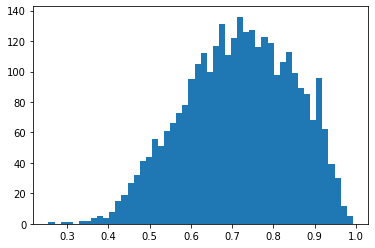

In [67]:
plt.hist(county_cases['good_masking_practices'], bins = 50)
;

In [68]:
election = pd.read_csv('./data/countypres_2000-2020.csv', dtype={'county_fips':str})

In [69]:
#fixing fips codes
fixed_list = []
for fips_code in list(election['county_fips']):
    if len(str(fips_code)) == 4:
        fixed_list.append('0' + str(fips_code))
    else:
        fixed_list.append(str(fips_code))
        
election['county_fips'] = fixed_list

In [70]:
election=election[election['year']==2020]

In [71]:
#splitting the data into trump and biden votes
trump_votes = election[election['candidate']=='DONALD J TRUMP']

In [72]:
#summing the votes by county so that all voting methods are included in the number of votes
tot_trump_votes = pd.DataFrame(trump_votes.groupby('county_fips')['candidatevotes'].sum())
tot_trump_votes.reset_index(inplace=True)
tot_trump_votes.rename(columns={'candidatevotes':'trump_votes'},inplace=True)

#adding the info that we lost from the original df
trump_votes = trump_votes[['county_fips','totalvotes']]
trump_votes.drop_duplicates(keep='first', inplace=True)

tot_trump_votes = tot_trump_votes.merge(trump_votes, on='county_fips', how='left')

In [73]:
biden_votes = election[election['candidate']=='JOSEPH R BIDEN JR']
biden_votes.shape

(5117, 12)

In [74]:
#summing the votes by county so that all voting methods are included in the number of votes
tot_biden_votes = pd.DataFrame(biden_votes.groupby('county_fips')['candidatevotes'].sum())
tot_biden_votes.reset_index(inplace=True)
tot_biden_votes.rename(columns={'candidatevotes':'biden_votes'},inplace=True)

#adding the info that we lost from the original df
biden_votes = biden_votes[['county_fips','totalvotes']]
biden_votes.drop_duplicates(keep='first', inplace=True)

tot_biden_votes = tot_biden_votes.merge(biden_votes, on='county_fips', how='left')

#### merge the trump and biden voting info together again 

In [75]:
election = tot_biden_votes.merge(tot_trump_votes, on='county_fips', how='left')
election.drop(columns=['totalvotes_x'],inplace=True)
election.rename(columns={'totalvotes_y':'total_votes', 'county_fips':'county_fips_code'}, inplace=True)

In [76]:
county_cases = county_cases.merge(election, on='county_fips_code', how='left')

In [77]:
county_cases.isnull().sum()

county                              0
county_fips_code                    0
cases                               0
deaths                              0
stname                              0
ctyname                             0
tot_pop                             0
deaths_per_hun_thou                 0
cnty_name                           1
unemployment_rate                   1
med_cases_per_100k_change           0
med_per_test_results_positive      18
transmission_level_high             0
transmission_level_low              0
transmission_level_moderate         0
transmission_level_substantial      0
state                               0
InBedsOccAnyPat__Numbeds_Est        1
InBedsOccCOVID__Numbeds_Est         1
ICUBedsOccAnyPat__N_ICUBeds_Est     1
cases_per_10k                       0
high_transmission                   0
mask_never                          0
mask_rarely                         0
mask_sometimes                      0
mask_frequently                     0
mask_always 

In [78]:
#https://www.openintro.org/data/?data=county_complete
land = pd.read_csv('./data/county_complete.csv', dtype={'fips':str})

#fixing fips codes
fixed_list = []
for fips_code in list(land['fips']):
    if len(str(fips_code)) == 4:
        fixed_list.append('0' + str(fips_code))
    else:
        fixed_list.append(str(fips_code))
        
land['fips'] = fixed_list

#grabbing relevant data
land = land[['fips','area_2010']]

#renaming columns for merging
land.rename(columns={'fips':'county_fips_code', 'area_2010':'land_area_sqmi'},inplace=True)


In [79]:
county_cases = county_cases.merge(land, on='county_fips_code', how='left')

In [80]:
#creating a variable for population density
county_cases['population_density'] = county_cases['tot_pop']/county_cases['land_area_sqmi']

### Importing and Cleaning Hospital Data

In [82]:
hos_df = pd.read_csv('./data/COVID-19_Reported_Patient_Impact_and_Hospital_Capacity_by_Facility.csv')

In [83]:
# selecting the most recent data
hos_df = hos_df[hos_df.collection_week == '2021/12/31']
hos_df.reset_index(inplace=True, drop=True)
hos_df.drop('collection_week', axis=1, inplace=True)

In [84]:
# selecting columns for analysis
hos_df = hos_df[['fips_code', 
         'total_beds_7_day_sum',
         'inpatient_beds_7_day_sum',
         'inpatient_beds_used_7_day_sum',
         'inpatient_beds_used_covid_7_day_sum',
         'total_icu_beds_7_day_sum', 
         'icu_beds_used_7_day_sum', 
         'total_staffed_adult_icu_beds_7_day_sum',
         'staffed_icu_adult_patients_confirmed_covid_7_day_sum',
         'total_adult_patients_hospitalized_confirmed_covid_7_day_sum']]

In [85]:
# drop all fips codes that are missing and change type
hos_df.drop(hos_df[hos_df.fips_code.isnull()].index, inplace=True)
hos_df.fips_code = hos_df.fips_code.astype('int64')

In [86]:
# drop small number of missing values
hos_df.dropna(inplace=True)

In [87]:
hos_df = hos_df.replace(-999999, 0, regex=True)
hos_df.isnull().sum()

fips_code                                                      0
total_beds_7_day_sum                                           0
inpatient_beds_7_day_sum                                       0
inpatient_beds_used_7_day_sum                                  0
inpatient_beds_used_covid_7_day_sum                            0
total_icu_beds_7_day_sum                                       0
icu_beds_used_7_day_sum                                        0
total_staffed_adult_icu_beds_7_day_sum                         0
staffed_icu_adult_patients_confirmed_covid_7_day_sum           0
total_adult_patients_hospitalized_confirmed_covid_7_day_sum    0
dtype: int64

In [88]:
#Group hospitals by FIPS code

hos_df = hos_df.groupby(by=hos_df['fips_code'])[
         'total_beds_7_day_sum',
         'inpatient_beds_used_7_day_sum',
         'inpatient_beds_used_covid_7_day_sum',
         'inpatient_beds_7_day_sum', 
         'total_icu_beds_7_day_sum', 
         'total_staffed_adult_icu_beds_7_day_sum',
         'icu_beds_used_7_day_sum',
        'staffed_icu_adult_patients_confirmed_covid_7_day_sum',
    'total_adult_patients_hospitalized_confirmed_covid_7_day_sum'].sum().astype('int64')

hos_df.reset_index(inplace=True)

In [89]:
# fills '0' result percentage calculations with 0
hos_df = hos_df.fillna(0.0)

In [90]:
#rename fips columns for future merging
hos_df.rename(columns={'fips_code':'county_fips_code'}, inplace=True)

In [91]:
# #save data as csv
# hos_df.to_csv('./data/hospital-impact-and-capacity.csv')

### Re-import hospital data for merging

In [92]:
hospital_capacity = hos_df

# hospital_capacity = pd.read_csv('./data/hospital-impact-and-capacity.csv', dtype={'county_fips_code':str})
# hospital_capacity.drop(columns=['Unnamed: 0'], inplace=True)

In [93]:
#fixing fips codes
fixed_list = []
for fips_code in list(hospital_capacity['county_fips_code']):
    if len(str(fips_code)) == 4:
        fixed_list.append('0' + str(fips_code))
    else:
        fixed_list.append(str(fips_code))
        
hospital_capacity['county_fips_code'] = fixed_list

In [94]:
hospital_capacity.head()

,county_fips_code,total_beds_7_day_sum,inpatient_beds_used_7_day_sum,inpatient_beds_used_covid_7_day_sum,inpatient_beds_7_day_sum,total_icu_beds_7_day_sum,total_staffed_adult_icu_beds_7_day_sum,icu_beds_used_7_day_sum,staffed_icu_adult_patients_confirmed_covid_7_day_sum,total_adult_patients_hospitalized_confirmed_covid_7_day_sum
0,01001,763,509,136,623,42,42,55,10,128
1,01003,3051,2017,237,2624,225,225,208,32,233
2,01005,349,180,13,300,35,35,26,0,13
3,01007,238,89,10,210,0,0,0,0,10
4,01009,392,128,13,322,42,42,24,0,21


In [95]:
county_cases = county_cases.merge(hospital_capacity, on='county_fips_code', how='left')

In [96]:
county_cases.shape

(3133, 42)

### Cleaning vaccine data

In [98]:
#import vaccine data
vac_df = pd.read_csv('./data/COVID-19_Vaccinations_in_the_United_States_County.csv')

In [99]:
# selecting the most recent data
vac_df = vac_df[vac_df['Date'] == '01/18/2022']

In [100]:
# selecting columns for analysis
vac_df = vac_df[['FIPS','Completeness_pct','SVI_CTGY']]

In [101]:
vac_df.isnull().sum()

FIPS                 0
Completeness_pct     0
SVI_CTGY            64
dtype: int64

In [102]:
# drop all rows that don't have a SVI category in order to dummify it
vac_df.dropna(inplace=True)

vac_df = pd.get_dummies(vac_df, columns = ['SVI_CTGY'], prefix = 'SVI_')

In [103]:
#rename FIPS column for merging purposes
vac_df.rename(columns={'FIPS':'county_fips_code'}, inplace=True)

In [104]:
# Renaming completness_pct
vac_df.rename(columns={'Completeness_pct':'county_vac_pct'}, inplace=True)

In [105]:
#Sort by fips code and reset index
vac_df = vac_df.sort_values(by='county_fips_code')
vac_df.reset_index(inplace=True, drop=True)

In [106]:
# vac_df.to_csv('./data/county-amount-vac-and-svi.csv')

### Re-importing the vaccine data for merging

In [107]:
vax = vac_df
# vax = pd.read_csv('./data/county-amount-vac-and-svi.csv', dtype={'county_fips_code':str})
# vax.drop(columns=['Unnamed: 0'], inplace = True)

In [108]:
#fixing fips codes
fixed_list = []
for fips_code in list(vax['county_fips_code']):
    if len(str(fips_code)) == 4:
        fixed_list.append('0' + str(fips_code))
    else:
        fixed_list.append(str(fips_code))
        
vax['county_fips_code'] = fixed_list

In [109]:
vax.head()

,county_fips_code,county_vac_pct,SVI__A,SVI__B,SVI__C,SVI__D
0,01001,92.8,0,1,0,0
1,01003,92.8,1,0,0,0
2,01005,92.8,0,0,0,1
3,01007,92.8,0,0,1,0
4,01009,92.8,0,1,0,0


In [110]:
county_cases = county_cases.merge(vax, on='county_fips_code', how='left')

### Importing and cleaning county demographic data

In [111]:
# reads in dataset for county ethnicity
character_df = pd.read_csv('./data/cc-est2019-alldata.csv', dtype={'STATE':str, 'COUNTY':str},
                           encoding = "ISO-8859-1")

# Converts dataframe columns to snake case
character_df.columns = character_df.columns.str.replace(' ', '_').str.lower()
# trying to drop index column 
character_df.reset_index(inplace=True)

In [112]:
# Creating county fips code to match covid deaths dataset
character_df['county_fips_code'] = character_df['state'] + character_df['county']
character_df.head()

,index,sumlev,state,county,stname,ctyname,year,agegrp,tot_pop,tot_male,...,hwac_female,hbac_male,hbac_female,hiac_male,hiac_female,haac_male,haac_female,hnac_male,hnac_female,county_fips_code
0,0,50,01,001,Alabama,Autauga County,1,0,54571,26569,...,538,57,48,26,32,9,11,19,10,01001
1,1,50,01,001,Alabama,Autauga County,1,1,3579,1866,...,56,9,5,4,1,0,0,2,1,01001
2,2,50,01,001,Alabama,Autauga County,1,2,3991,2001,...,66,2,3,2,7,2,3,2,0,01001
3,3,50,01,001,Alabama,Autauga County,1,3,4290,2171,...,57,13,7,5,5,2,1,1,1,01001
4,4,50,01,001,Alabama,Autauga County,1,4,4290,2213,...,44,7,5,0,2,2,1,3,1,01001


The columns agegrop is comprised of 19 different numbers. 0 represents all ages whereas every number after represents four year age gaps. Except for 18 which represents ages 85 years or older. We will only be using rows that are agegrp zeros and year 12 as these rows represent data from all age groups from 2019.

In [113]:
character_df = character_df[character_df['year'] == 12 ] 
character_df = character_df[character_df['agegrp'] == 0 ] 

In [114]:
# List of columns to be used in analysis
keep_list = ['tot_male', 'tot_female', 'wa_male', 'wa_female', 'ba_male', 'ba_female',
             'ia_male', 'ia_female', 'aa_male', 'aa_female', 'na_male', 'na_female',
             'state', 'county', 'stname', 'ctyname', 'tot_pop', 'agegrp', 'county_fips_code']

# Makes list of columns to be dropped 
drop_list = [col for col in character_df if col not in keep_list]
# Dropping unnecessary columns 
character_df.drop(columns= drop_list, inplace=True)

In [115]:
# creates columns for total base population of each ethnicity
character_df['tot_wa_pop'] = character_df.wa_male + character_df.wa_female
character_df['tot_ba_pop'] = character_df.ba_male + character_df.ba_female
character_df['tot_ia_pop'] = character_df.ia_male + character_df.ia_female
character_df['tot_aa_pop'] = character_df.aa_male + character_df.aa_female
character_df['tot_na_pop'] = character_df.na_male + character_df.na_female

In [116]:
# Creates drop list for male and female eth columns
drop_eth_col = [col for col in character_df if col.endswith('male') and not col.startswith('tot')]

# Dropping extra eth columns 
character_df.drop(columns=drop_eth_col, inplace=True)

In [117]:
# # Reading in dataframe from COVID-19 CASE SURVEILLANCE notebook 
# covid_deaths_df = pd.read_csv('data/covid-cases-deaths-per-us-counties.csv',
#                               dtype={'county_fips_code':str})
# covid_deaths_df.shape

In [118]:
# Dropping matching and unneccessary columns 
character_df.drop(columns=['tot_pop', 'state', 'county', 'stname', 'agegrp', 'ctyname'], inplace=True)

In [119]:
# Totals all minority groups and creates minority_group_total column
character_df['minority_group_total'] = character_df.tot_ba_pop
+ character_df.tot_ia_pop
+ character_df.tot_aa_pop
+ character_df.tot_na_pop

209        58
437       154
665        52
893        26
1121       67
         ... 
715445     69
715673     33
715901     31
716129      6
716357      2
Name: tot_na_pop, Length: 3142, dtype: int64

In [120]:
# character_df.to_csv('./data/covid_deaths_by_ethnicity.csv')

### Re-importing and merging

In [121]:
demographics = character_df
# demographics = pd.read_csv('./data/covid_deaths_by_ethnicity.csv', dtype={'county_fips_code':str})
# demographics.drop(columns=['Unnamed: 0'], inplace=True)


In [122]:
demographics = demographics[['county_fips_code',
                             'tot_male',
                             'tot_female',
                             'tot_wa_pop',
                             'tot_ba_pop',
                             'tot_aa_pop',
                             'tot_na_pop',
                             'minority_group_total']]

In [123]:
county_cases = county_cases.merge(demographics, on='county_fips_code', how='left')

In [124]:
county_cases.head()

,county,county_fips_code,cases,deaths,stname,ctyname,tot_pop,deaths_per_hun_thou,cnty_name,unemployment_rate,...,SVI__B,SVI__C,SVI__D,tot_male,tot_female,tot_wa_pop,tot_ba_pop,tot_aa_pop,tot_na_pop,minority_group_total
0,Autauga,01001,12738,163.0,Alabama,Autauga County,55869.0,291.753924,"Autauga County, AL",4.9,...,1.0,0.0,0.0,27092,28777,42607,11237,656,58,11237
1,Baldwin,01003,47143,605.0,Alabama,Baldwin County,223234.0,271.016064,"Baldwin County, AL",5.6,...,0.0,0.0,0.0,108247,114987,195198,19593,2380,154,19593
2,Barbour,01005,4741,83.0,Alabama,Barbour County,24686.0,336.222960,"Barbour County, AL",7.0,...,0.0,0.0,1.0,13064,11622,12134,11906,116,52,11906
3,Bibb,01007,5385,95.0,Alabama,Bibb County,22394.0,424.220773,"Bibb County, AL",6.6,...,0.0,1.0,0.0,11929,10465,17191,4763,48,26,4763
4,Blount,01009,12648,203.0,Alabama,Blount County,57826.0,351.053159,"Blount County, AL",4.1,...,1.0,0.0,0.0,28472,29354,55412,978,185,67,978


In [125]:
county_cases.to_csv('./data/merged_dataset.csv', index=False)

In [126]:
pd.read_csv('./data/merged_dataset.csv').isnull().sum()

county                                                           0
county_fips_code                                                 0
cases                                                            0
deaths                                                           0
stname                                                           0
ctyname                                                          0
tot_pop                                                          0
deaths_per_hun_thou                                              0
cnty_name                                                        1
unemployment_rate                                                1
med_cases_per_100k_change                                        0
med_per_test_results_positive                                   18
transmission_level_high                                          0
transmission_level_low                                           0
transmission_level_moderate                                   

In [127]:
county_cases.shape

(3133, 54)